In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import silhouette_visualizer

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/samsung/Day3/for_clustering.csv", sep=';')
df.head()

Id_client  InWeek_amount  InWeek_SKU  Checkinmonth_average  \
0       5743         269.53          46                     2   
1       5756         359.99          36                     4   
2       5781         329.32           9                     4   
3       5801         385.81          51                     8   
4       5808         310.28           8                     4   

   Checkamount_mean  Count_transac  Total_amount  Total_SKU_qnt  \
0            102.93            119         12399         1114.0   
1            100.28            130         12960         1024.0   
2            102.20             29          2964          170.0   
3             48.86            404         19676         2486.0   
4            108.58             25          2482          255.0   

   Count_departments  Count_shop  ...  Cat_babyprod_share  \
0                 26           4  ...                0.08   
1                 29           3  ...                0.04   
2                 24           1  ...                0.11   
3                 33           3  ...                0.03   
4                 26           2  ...                0.04   

   Communication_3month  Response_communcation  SKU_LastMonthqnt  \
0                     1                      1                60   
1                     1                      0                91   
2                     1                      1                13   
3                     1                      0                68   
4                     1                      1                22   

   Checks_LastMonthqnt  Amount_LastMonth Discount  Discount_LastMonth  \
0                   12            963.01        1                   1   
1                   15           1534.69        1                   1   
2                    2           1514.48        1                   1   
3                   35           1872.24        1                   1   
4                    3            557.97        1                   1   

  _SEGMENT_  EM_SEGMENT  
0         2           2  
1         2           2  
2         3           3  
3         2           2  
4         1           1  

[5 rows x 45 columns]

In [ ]:
df.isna().sum()

Id_client                     0
InWeek_amount                 0
InWeek_SKU                    0
Checkinmonth_average          0
Checkamount_mean              0
Count_transac                 0
Total_amount                  0
Total_SKU_qnt                 0
Count_departments             0
Count_shop                    0
Count_city                    0
Tenure                        0
SKU_meanbytransac             0
Amount_last6mnth              0
Check_qntlast6mnth            0
SKU_price_mean                0
Gender                      241
Age                         152
Age_group                   152
Interval_visit                0
Days_pastvisit                0
Cat_householdchem_qnt         0
Cat_householdchem_amount      0
Cat_householdchem_share       0
Cat_careproducts_qnt          0
Cat_careproducts_amount       0
Cat_careproducts_share        0
Cat_toiletries_qnt            0
Cat_toiletries_amount         0
Cat_toiletries_share          0
Cat_healthwellnes_qnt         0
Cat_heal

Строк с пропусками очень мало, по сравнению со всем набором данных, поэтому просто удалим их

In [ ]:
df.dropna(inplace = True)
df.isna().sum().sum()

0

In [ ]:
df.shape

(27267, 45)

In [ ]:
df.dtypes

Id_client                     int64
InWeek_amount               float64
InWeek_SKU                    int64
Checkinmonth_average          int64
Checkamount_mean            float64
Count_transac                 int64
Total_amount                  int64
Total_SKU_qnt               float64
Count_departments             int64
Count_shop                    int64
Count_city                    int64
Tenure                        int64
SKU_meanbytransac           float64
Amount_last6mnth            float64
Check_qntlast6mnth            int64
SKU_price_mean              float64
Gender                       object
Age                         float64
Age_group                    object
Interval_visit                int64
Days_pastvisit                int64
Cat_householdchem_qnt         int64
Cat_householdchem_amount      int64
Cat_householdchem_share     float64
Cat_careproducts_qnt          int64
Cat_careproducts_amount       int64
Cat_careproducts_share      float64
Cat_toiletries_qnt          

Агоритмы кластеризации работают с числовыми данными, поэтому необходимо что то сделать с признаками типа object

In [ ]:
df.columns[df.dtypes == 'object']

Index(['Gender', 'Age_group'], dtype='object')

In [ ]:
print(df.Gender.value_counts())
print()
df.Age_group.value_counts()

F    18781
M     8486
Name: Gender, dtype: int64



25-35    7121
35-45    6875
45-55    4941
55-65    4071
65+      2354
0-25     1905
Name: Age_group, dtype: int64

In [ ]:
le = preprocessing.LabelEncoder()
df.Gender = le.fit_transform(df.Gender)

le = preprocessing.LabelEncoder()
df.Age_group = le.fit_transform(df.Age_group)

В данных имеется много признаков типа int. Проверим, все ли из них имеют смысл

In [ ]:
lengths = []
for i in range(len(list(df.columns[df.dtypes == 'int64']))):
  lengths.append(len(df.loc[:, list(df.columns[df.dtypes == 'int64'])].iloc[:, i].value_counts()))

Оставим те признаки, у которых мало уникальных значений

In [ ]:
small_counts = np.array(df.columns[df.dtypes == 'int64'])[np.array(lengths) < 5]
small_counts

array(['Gender', 'Communication_3month', 'Response_communcation',
       'Discount', 'Discount_LastMonth', '_SEGMENT_', 'EM_SEGMENT'],
      dtype=object)

In [ ]:
df.loc[:, list(small_counts)]

Gender  Communication_3month  Response_communcation  Discount  \
0           0                     1                      1         1   
1           0                     1                      0         1   
2           0                     1                      1         1   
3           0                     1                      0         1   
4           0                     1                      1         1   
...       ...                   ...                    ...       ...   
27503       0                     1                      1         1   
27504       0                     1                      1         1   
27505       0                     1                      1         1   
27506       0                     1                      1         1   
27507       1                     1                      1         1   

       Discount_LastMonth  _SEGMENT_  EM_SEGMENT  
0                       1          2           2  
1                       1          2           2  
2                       1          3           3  
3                       1          2           2  
4                       1          1           1  
...                   ...        ...         ...  
27503                   1          3           3  
27504                   1          1           1  
27505                   0          3           3  
27506                   1          3           3  
27507                   1          1           1  

[27267 rows x 7 columns]

Видно, что есть два непонятных одинаковых столбца - _SEGMENT_ и EM_SEGMENT. Подозреваю, что это либо ответы, либо специально вставленный шум. Думаю, их в любом случае нужно удалить

Далее стоит проверить остальные признаки на распределение объектов по значениям


In [ ]:
df.loc[:, "Gender"].value_counts()

0    18781
1     8486
Name: Gender, dtype: int64

In [ ]:
df.loc[:, "Communication_3month"].value_counts()

1    27266
0        1
Name: Communication_3month, dtype: int64

In [ ]:
df.loc[:, "Response_communcation"].value_counts()

1    14931
0    12336
Name: Response_communcation, dtype: int64

In [ ]:
df.loc[:, "Discount"].value_counts()

1    27214
0       53
Name: Discount, dtype: int64

In [ ]:
df.loc[:, "Discount_LastMonth"].value_counts()

1    25113
0     2154
Name: Discount_LastMonth, dtype: int64

У признаков Communication_3month и Discount почти все объекты принадлежат одному классу. Вряд ли они помогут в задаче кластеризации, удалим их. ID клиентов, само собой, тоже

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


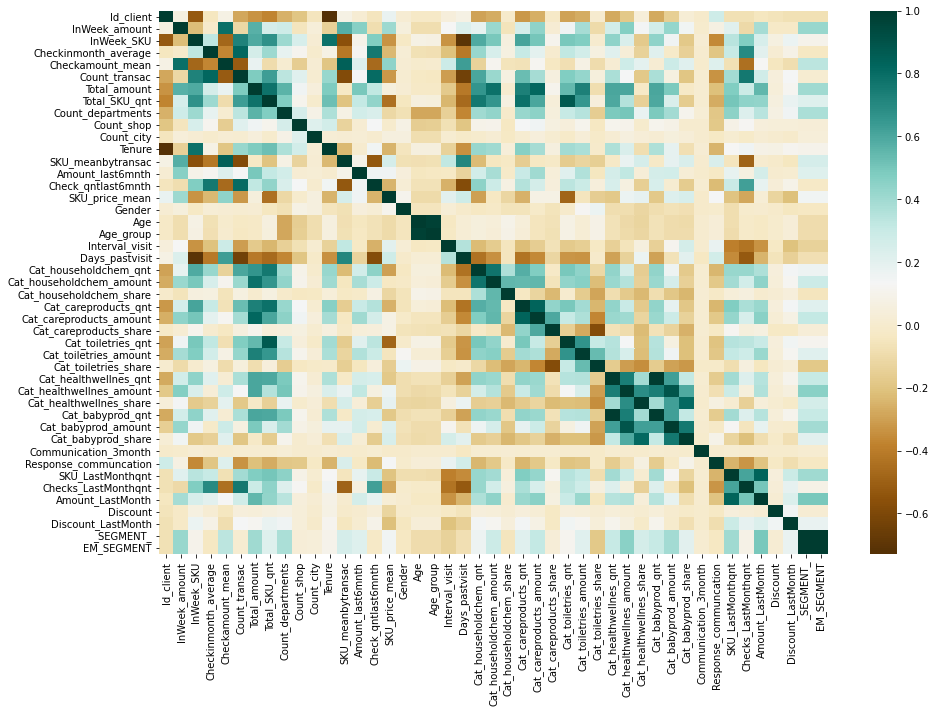

In [ ]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns)

df_corr = df.corr()

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, mask=np.zeros_like(df_corr, dtype=np.bool), cmap = "BrBG",ax=ax)
plt.show()

Видно, что Age и Age_group почти иднетичные признаки. Один из них можно удалить

In [ ]:
deleted = df.loc[:, ['Id_client', '_SEGMENT_', 'EM_SEGMENT', 'Age', 'Communication_3month', 'Discount']]

df = df.drop(['Id_client', '_SEGMENT_', 'EM_SEGMENT', 'Age', 'Communication_3month', 'Discount'], axis=1)

Теперь построим графики силуэта для разного количества кластеров

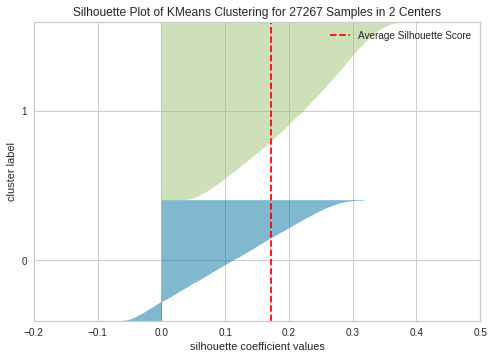

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0072145510>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, random_state=210))

In [ ]:
silhouette_visualizer(KMeans(2, random_state=210), df, colors='yellowbrick')

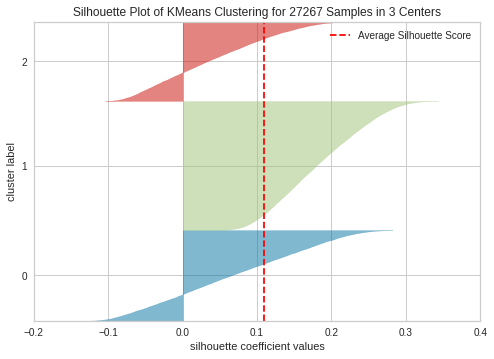

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0071ff6e10>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, random_state=127))

In [ ]:
silhouette_visualizer(KMeans(3, random_state=127), df, colors='yellowbrick')

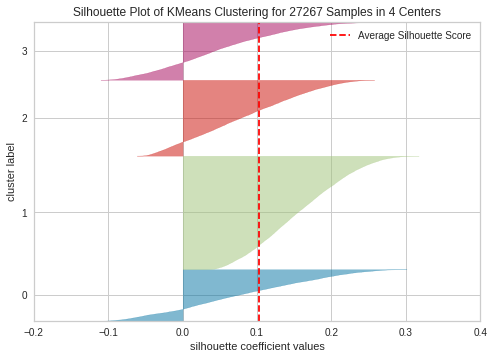

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f007211f050>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=240))

In [ ]:
silhouette_visualizer(KMeans(4, random_state=240), df, colors='yellowbrick')

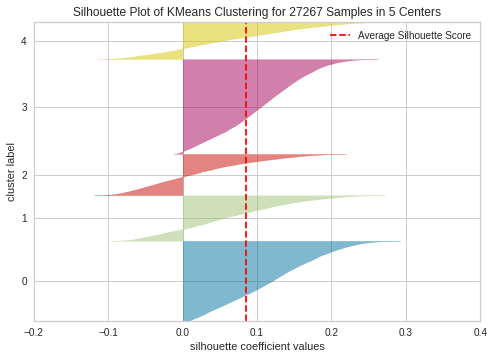

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0072580890>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, random_state=40))

In [ ]:
silhouette_visualizer(KMeans(5, random_state=40), df, colors='yellowbrick')

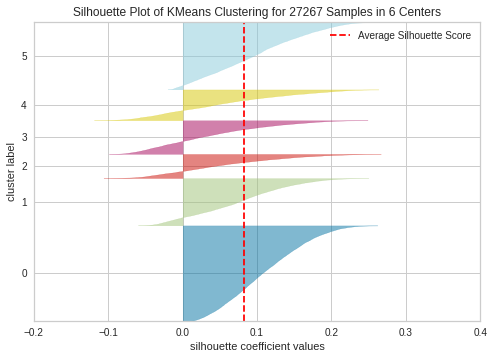

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0072fac890>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=6, random_state=140))

In [ ]:
silhouette_visualizer(KMeans(6, random_state=140), df, colors='yellowbrick')

Данные очень плохо группируются. Видно, что коэффициент силуэта (почти в каждом кластере и для любого количества кластеров) очень плавно перетекает в ноль, а иногда и в отрицательные значения. Это говорит о том, что много объектов лежит в пограничных зонах между кластерами и их трудно определить к одному из них.
Это свойство данных ограничивает использование алгоритмов на основе плотности точек, например DBSCAN.

Отрисуем для примера разбиение с помощью к-средних по какой нибудь паре признаков

In [ ]:
%%time
clusterer = KMeans(n_clusters=4)
cluster_labels = clusterer.fit_predict(df)

For n_clusters = 4 , the inertia is : 194155003011.87476
CPU times: user 2.55 s, sys: 653 ms, total: 3.2 s
Wall time: 1.67 s


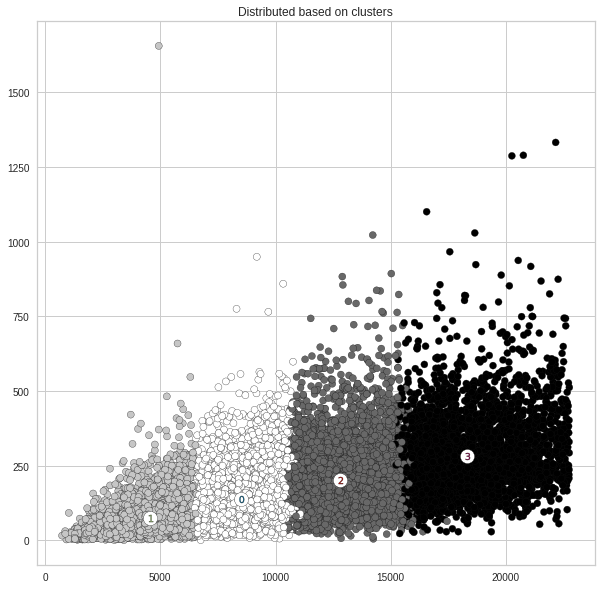

In [ ]:
plt.figure(figsize=(10,10))

plt.scatter(df.iloc[:, 5], df.iloc[:, 19], c=cluster_labels, edgecolor='k')

centers = clusterer.cluster_centers_

plt.scatter(centers[:, 5], centers[:, 19], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[5], c[19], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')
    
plt.title("Distributed based on clusters");

В выбраной паре признаков (и в нескольких других, которые я отрисовывал) разбиение происходит в облаке точек, которые выглядят как один кластер.

Посмотрим на остальные попарные графики

CPU times: user 37.9 s, sys: 514 ms, total: 38.4 s
Wall time: 39.3 s


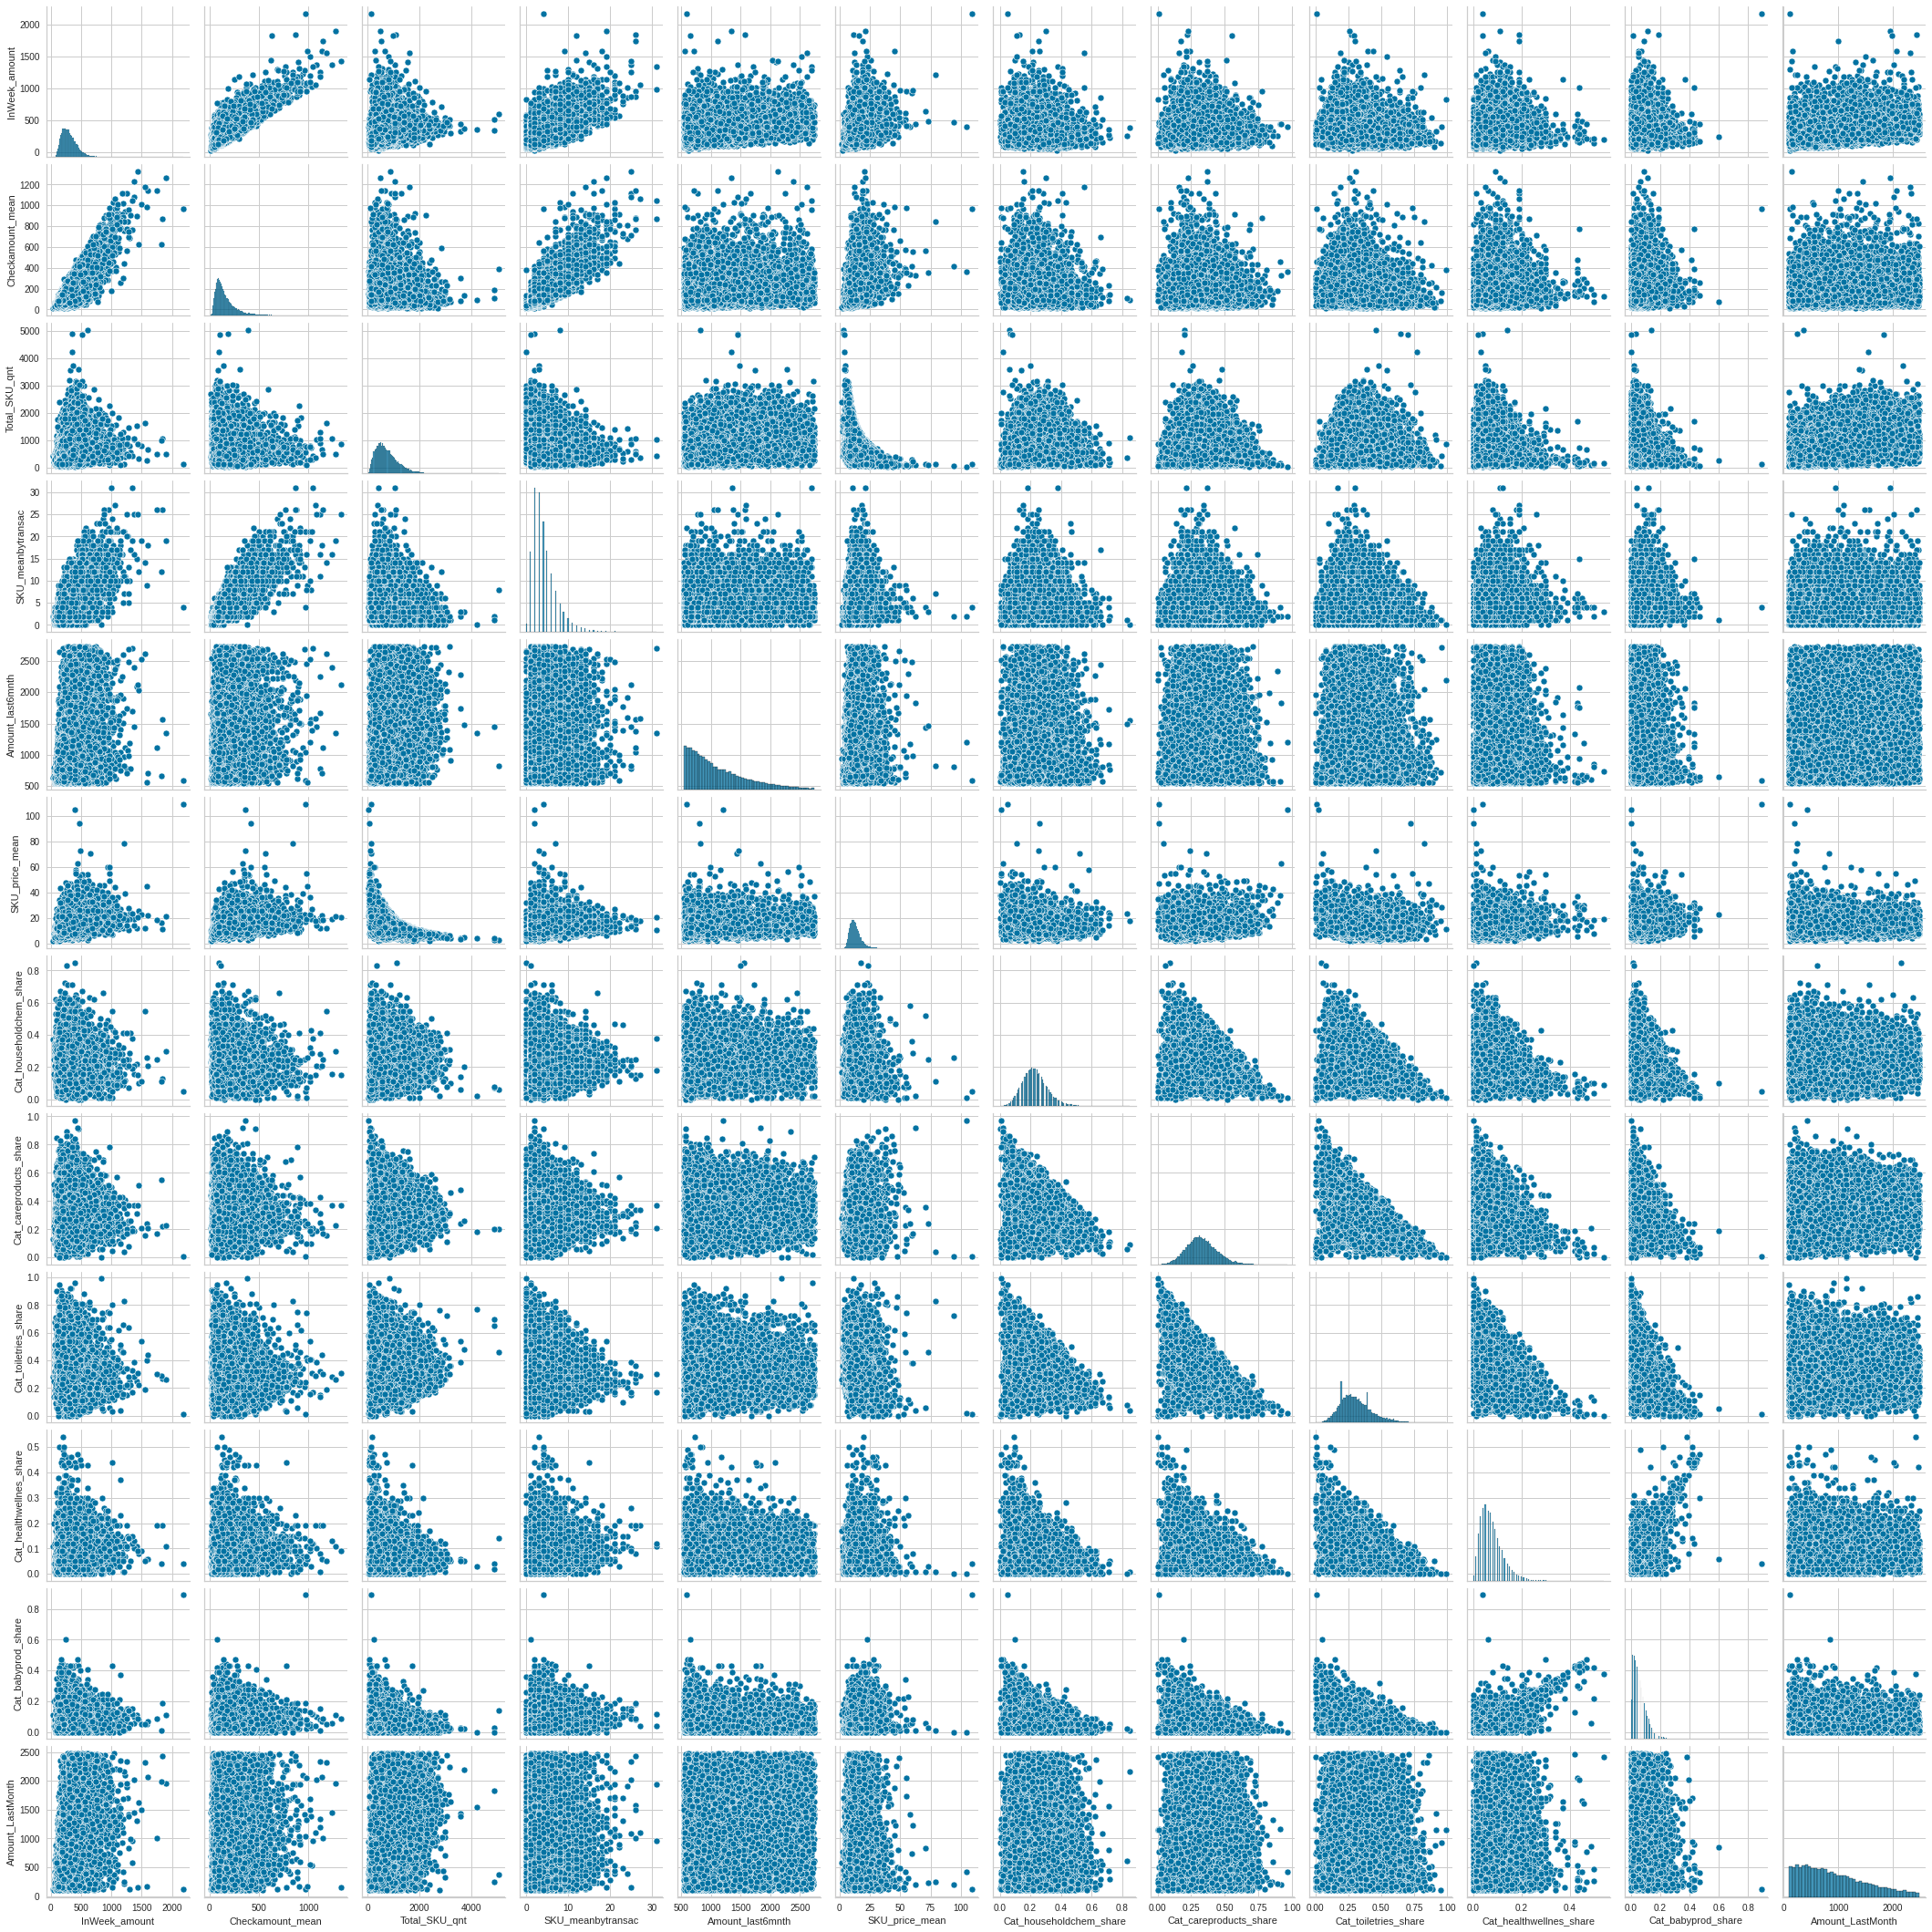

In [ ]:
%%time
sns.pairplot(df.loc[:,df.dtypes == 'float64'])

CPU times: user 23.9 s, sys: 228 ms, total: 24.2 s
Wall time: 26.6 s


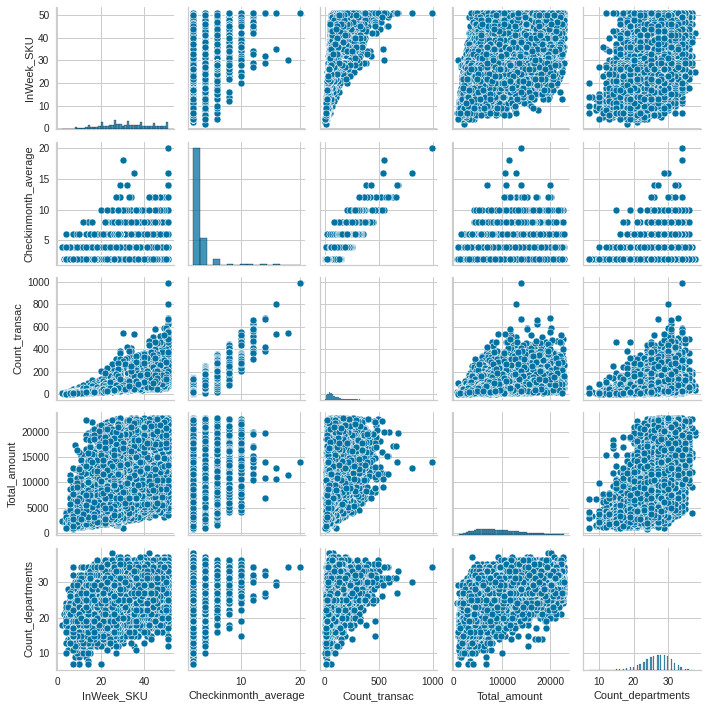

In [ ]:
%%time
sns.pairplot(df.loc[:,df.dtypes != 'float64'].iloc[:, 0:5], height = 2)

Такие графики объясняют средний коэффициент силуэта = 0.1, полученный выше на графиках визуализации силуэта

Попробуем найти оптимальное количество кластеров с помощью метода локтя

In [ ]:
%%time

inertia_df = pd.DataFrame(data=[], index=range(2, 9), columns=['inertia'])
                                                             
for n_clusters in range(2, 9):
    clusterer = KMeans(n_clusters=n_clusters,  random_state=22)
    cluster_labels = clusterer.fit_predict(df)
    
    inertia_df.loc[n_clusters] = clusterer.inertia_  

CPU times: user 29.2 s, sys: 4.16 s, total: 33.3 s
Wall time: 23.2 s


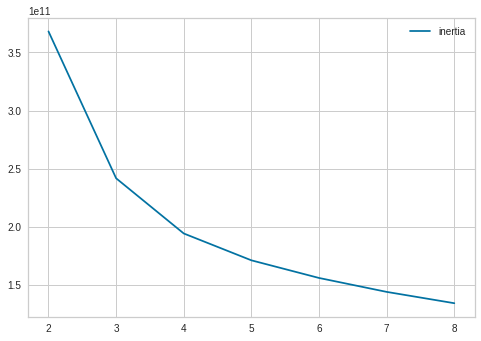

In [ ]:
inertia_df.plot()

Исходя из графика, кластеров может быть либо 3, либо 4.

И всё же, кластеризация - задача без правильного ответа, и необходимое разбиение должно обуславливаться задачей бизнеса. Можно разбить пользователей на кластеры, посмотреть на людей, которые являются центрами кластеров и принимать решение в зависимости от цели разбиения, например, определение портрета человека, приносящего большую часть прибыли. 

Так же, имеет смысл подумать над признаками. Если знать их описание, можно составить гипотезы о наиболее и наименее полезных, и попробовать сделать разбиение на уже отобранных признаках.

Я выберу количество кластеров, равное 3. К тому же, в исходных данных имелся столбец, под названием _SEGMENT_, и если это один из вариантов разбиения, то будет с чем сравнить результат.

In [ ]:
%%time
clustering = DBSCAN(eps=1000000, min_samples=2).fit(df)
print(pd.Series(clustering.labels_).value_counts())

0    27267
dtype: int64
CPU times: user 13 s, sys: 7.87 s, total: 20.8 s
Wall time: 17.3 s


Как я и говорил, DBSCAN бесполезен на этих данных и выдаёт неадекватный результат

In [ ]:
%%time
clustering = AgglomerativeClustering(linkage = 'single').fit(df)
print(pd.Series(clustering.labels_).value_counts())

0    27266
1        1
dtype: int64
CPU times: user 25.4 s, sys: 255 ms, total: 25.6 s
Wall time: 25.9 s


Агломеративная кластеризация без указания количества кластеров показывает тот же результат, что и DBSCAN

In [ ]:
%%time
clustering = AgglomerativeClustering(n_clusters = 3).fit(df)
clustering_AC_labels = clustering.labels_
print(pd.Series(clustering.labels_).value_counts())

0    17334
2     5924
1     4009
dtype: int64
CPU times: user 1min 37s, sys: 566 ms, total: 1min 37s
Wall time: 1min 43s


In [ ]:
%%time
clustering = KMeans(n_clusters=3, random_state = 42)
cluster_K_labels = clustering.fit_predict(df)
print(pd.Series(cluster_labels).value_counts())

0    11648
2    10375
1     5244
dtype: int64
CPU times: user 2.08 s, sys: 616 ms, total: 2.69 s
Wall time: 1.67 s


In [ ]:
%%time
clustering = GaussianMixture(n_components=3, random_state=42).fit(df)
clustering_gm_labels = clustering.predict(df)
print(pd.Series(clustering_gm_labels).value_counts())

2    16291
0     8339
1     2637
dtype: int64
CPU times: user 7.39 s, sys: 3.46 s, total: 10.9 s
Wall time: 12.1 s


In [ ]:
deleted._SEGMENT_.value_counts()

2    10843
3     8263
1     8161
Name: _SEGMENT_, dtype: int64

Распределение объектов по кластерам довольно различное для использованных алгоритмов и не соответствует распределению в столбце _SEGMENT_. Но как я уже сказал, необходимо дальнейшее исследование данных и понимание бизнес задачи.